In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as itools
import scipy as sc
from pathlib import Path


HERE=Path.cwd()


In [3]:
A = np.array([[-1.01887, 0.90506, -0.00215],
    [0.82225, -1.07741, -0.17555],
    [0, 0, -1.0000]])

# A = np.array([[1, 1],
#              [0, 1]])

# print('A=', A)
# print(A.shape)

# B = np.array([[0, 1],
#             [0, 1],
#             [1, 1]])

B = np.array([[0],
              [0],
             [1]])

# print('B=', B)


n = np.shape(A)[0]
m = np.shape(B)[1]
nu = (n+m)*(n+m+1)/2

M = 1*np.diag(np.ones(n))
# print('M=', M)

R = 1*np.diag(np.ones(m))

a_c = 50

a_u = 1

T_e = 30

T = 0.1


hh = 0.05
step = T/hh

# Wc = np.random.randn(int(nu),1)
# Wu = np.random.randn(n,m)

## these values work for classical q learning

# Wc = np.array([[-0.22254839],
#              [-0.09686478],
#              [-2.49695388],
#              [ 1.0668048 ],
#              [-1.60286281],
#              [-0.04247689],
#              [-1.33245457],
#              [ 0.77567967],
#              [ 0.45453406],
#              [-0.13830811]])

# Wu = np.array([[-0.98594133],
#              [-0.92315427],
#              [-0.9343827 ]])

## Another option for classical Q (preferred) ##

# Wc = np.array([[ 0.32246253],
#              [ 1.04928076],
#              [-0.30023645],
#              [ 1.0307823 ],
#              [-2.87651695],
#              [ 0.0506019 ],
#              [-0.49939763],
#              [ 0.93253367],
#              [ 2.02527102],
#              [-0.69536714]])

Wu = np.array([[ 0.63714726],
             [ 0.39491038],
             [-0.36248965]])


## another Option

# Wc = np.array([[ 0.52903463],
#              [ 0.85632812],
#              [-1.93135569],
#              [-0.1305188 ],
#              [-0.36593366],
#              [-0.02941726],
#              [ 0.97429185],
#              [-0.381754  ],
#              [ 0.02014093],
#              [ 0.92646002]])

Wc = np.array([[-1.02049333],
             [ 0.53928439],
             [ 1.04046673],
             [ 0.12192303],
             [ 1.6572383 ],
             [-1.23908658],
             [-0.46412798],
             [ 0.61206623],
             [-1.1653882 ],
             [-0.80742361]])


x = np.array([[1, 1, 0]]).T

# x = np.array([[1, 0]]).T
# e = np.zeros(x.shape)
# U = np.vstack((x,u,e))
u = np.matmul(Wu.T,x)
U = np.vstack((x,u))

Wu_vec = Wu.reshape((n*m,1))
p = 0.5*hh*(np.matmul(x.T, np.matmul(M, x)) + np.matmul(u.T, np.matmul((R), u)))


y = np.vstack((x,Wc,Wu_vec,p))
tspan = 50


In [4]:
print(Wc)
print(Wu)

[[-1.02049333]
 [ 0.53928439]
 [ 1.04046673]
 [ 0.12192303]
 [ 1.6572383 ]
 [-1.23908658]
 [-0.46412798]
 [ 0.61206623]
 [-1.1653882 ]
 [-0.80742361]]
[[ 0.63714726]
 [ 0.39491038]
 [-0.36248965]]


In [5]:
# Q-Function Creation #

def Qcreate(Wc, n=n, m=m, nu=nu):
    
    
    Q = np.zeros((n+m, n+m))
    idx = np.triu_indices(n+m)
    crit_p = Wc
    Q[idx] = crit_p.reshape((int(nu),))
    Q = Q + Q.T
    

    Qxx = Q[0:n,0:n]
    Quu = Q[n:n+m,n:n+m]
    Qxu = Q[0:n,n:n+m]
    
    
    M = 1*np.diag(np.ones(n))
    Z = np.zeros((m,n))
    addcol = np.vstack((-1*M,Z))
#     print(addcol)
#     print(Q)
    addrow = np.hstack((-1*M,Z.T,M))
    Q_b = np.hstack((Q,addcol))
    Q_b = np.vstack((Q_b,addrow))
    
    return Q, Qxx, Quu, Qxu, Q_b




In [6]:
# Euler's Method #

def euler_state(x, u, A_mat = A, B_mat = B, h = hh):
    states_sys = np.matmul(A_mat,x) + np.matmul(B_mat,u)
    x_n = x + h*states_sys
    
    return x_n

def euler_critic(U, p, p_p, U_p, Wc, Q_mat, h = hh, cs = a_c):
    
#     current_est = np.matmul(U.T, np.matmul(Q_mat, U))
#     past_est = np.matmul(U_p.T, np.matmul(Q_mat, U_p))
    integral_error = p - p_p
    
#     ec = 0.5*(current_est - past_est + integral_error)
    basis_idx = list(itools.combinations_with_replacement(range(n+m),2))
    
    phil = []
    phil_p = []
    for i,j in basis_idx:
        phil.append(U[i]*U[j])
        phil_p.append(U_p[i]*U_p[j])
        
    phi = np.array(phil).reshape(len(basis_idx))
    phi_p = np.array(phil_p).reshape(len(basis_idx))
        
        
    sigma = phi-phi_p
    ec = np.matmul(sigma.T, Wc) + integral_error
    critic_sys = -1*cs*(sigma/(1+np.dot(sigma,sigma))**2)*ec
    Wc_n = Wc + h*critic_sys.T
    return Wc_n

def euler_actor(x, Wa, Q_uu, Q_ux, h = hh, a_s = a_u):
    ea = np.matmul(Wa.T, x) + np.matmul(np.linalg.inv(Q_uu),np.matmul(Q_ux,x))
    phiu = x
    phiu_norm = phiu/(1+np.dot(phiu.T,phiu))**2
    actor_sys = -1*a_s*np.matmul(phiu_norm,ea.T)
    Wa_n = Wa + h*actor_sys
    return Wa_n
    



In [7]:
U_series = []
x_series = []
u_series = []
Wc_series = []
Wu_series = []
p_series = []



U_series.append(U)
x_series.append(x)
u_series.append(u)
Wc_series.append(Wc) 
Wu_series.append(Wu)
p_series.append(p)


for t in np.arange(hh,100,hh):
#     print('t=',t)
    x_n = euler_state(x_series[-1], u_series[-1])
    
    step = int(step)
#     print('Wc_series=',Wc_series)
    Q, Qxx, Quu, Qxu, Qb = Qcreate(Wc_series[-1])
    Qux = Qxu.T
    
    
    
    if len(p_series) < step:
        st = -1
#         p_pp = p_series[-step]
#         u_pp = u_series[-step]
#         x_pp = x_series[-step]
        
    else:
        st = -step
#         p_pp = p_series[-1]
#         u_pp = u_series[-1]
#         x_pp = x_series[-1]
    
    Wc_n = euler_critic(U_series[-1], p_series[-1], p_series[st], U_series[st], Wc_series[-1], Q)
    Wu_n = euler_actor(x, Wu_series[-1], Quu, Qux)
    
#     print('Wc_n = ', Wc_n)
    
    u_new = np.matmul(Wu_n.T,x_n)
    
    if t < T_e:
#         u_n = u_new + 0.2*np.exp(-0.0000001*t)*(np.sin(4*t**2)**2*np.cos(t**2)+np.sin(2**t)**2*np.cos(0.1*t)+np.sin(-1.2*t)**2*np.cos(0.5*t)+np.sin(t)**5+np.sin(1.12*t)**2+np.cos(2.4*t)*np.sin(2.4*t)**3)
        u_n = u_new  + 2*np.exp(-0.01*t)*(np.sin(100*t)+np.sin(t)**2*np.cos(t)+np.sin(2*t)**2*np.cos(0.1*t)+np.sin(-1.2*t)**2*np.cos(0.5*t)+np.sin(t)**5+np.sin(1.12*t)**2+np.cos(2.4*t)*np.sin(2.4*t)**3)
    else:
        u_n = u_new
        
        
#     p_past = np.matmul(x_series[-1].T, np.matmul(M, x_series[-1])) + np.matmul(u_series[-1].T, np.matmul((R), u_series[-1]))
    p_now = np.matmul(x_n.T, np.matmul(M, x_n)) + np.matmul(u_n.T, np.matmul((R), u_n))
    
    p_n = p_series[-1] + 0.5*hh*p_now
    
    x_series.append(x_n)
    Wc_series.append(Wc_n)
    Wu_series.append(Wu_n)
    u_series.append(u_n)
    
    
    U_n = np.vstack((x_n,u_n))
    U_series.append(U_n)
    p_series.append(p_n)
    


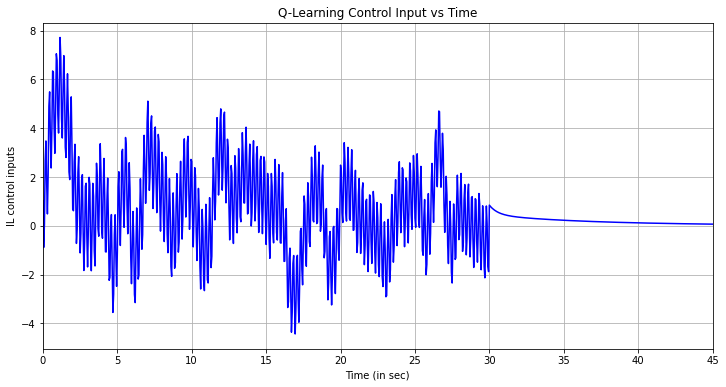

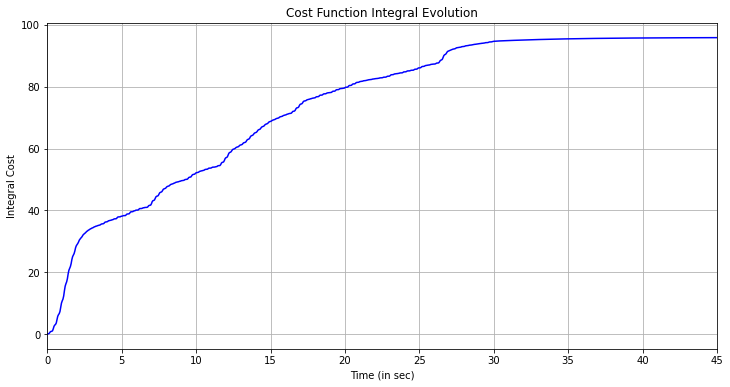

In [8]:
# Controller plot
fig3, ax3 = plt.subplots(figsize=(12, 6))
ax3.plot(np.arange(0,100,hh), np.array(u_series).reshape(2000), 'b')
plt.xlim([0, 45])
plt.title('Q-Learning Control Input vs Time')
plt.xlabel('Time (in sec)')
plt.ylabel('IL control inputs')
ax3.grid()
plt.show(fig3)

fig4, ax4 = plt.subplots(figsize=(12, 6))
ax4.plot(np.arange(0,100,hh), np.array(p_series).reshape(2000), 'b')
plt.xlim([0, 45])
plt.title('Cost Function Integral Evolution')
plt.xlabel('Time (in sec)')
plt.ylabel('Integral Cost')
ax4.grid()
plt.show(fig4)

In [68]:
## Reward loss ##

U_lseries = []
x_lseries = []
u_lseries = []
Wc_lseries = []
Wu_lseries = []
p_lseries = []



U_lseries.append(U)
x_lseries.append(x)
u_lseries.append(u)
Wc_lseries.append(Wc) 
Wu_lseries.append(Wu)
p_lseries.append(p)


for t in np.arange(hh,100,hh):
#     print('t=',t)
    x_n = euler_state(x_lseries[-1], u_lseries[-1])
    
    step = int(step)
#     print('Wc_series=',Wc_series)
    Q, Qxx, Quu, Qxu = Qcreate(Wc_lseries[-1])
    Qux = Qxu.T
    
    
    
    if len(p_lseries) < step:
        st = -1
#         p_pp = p_series[-step]
#         u_pp = u_series[-step]
#         x_pp = x_series[-step]
        
    else:
        st = -step
#         p_pp = p_series[-1]
#         u_pp = u_series[-1]
#         x_pp = x_series[-1]
    
    Wc_n = euler_critic(U_lseries[-1], p_lseries[-1], p_lseries[st], U_lseries[st], Wc_lseries[-1], Q)
    Wu_n = euler_actor(x, Wu_lseries[-1], Quu, Qux)
    
#     print('Wc_n = ', Wc_n)
    
    u_new = np.matmul(Wu_n.T,x_n)
    
    if t < T_e:
#         u_n = u_new + 0.2*np.exp(-0.0000001*t)*(np.sin(4*t**2)**2*np.cos(t**2)+np.sin(2**t)**2*np.cos(0.1*t)+np.sin(-1.2*t)**2*np.cos(0.5*t)+np.sin(t)**5+np.sin(1.12*t)**2+np.cos(2.4*t)*np.sin(2.4*t)**3)
        u_n = u_new  + 2*np.exp(-0.01*t)*(np.sin(100*t)+np.sin(t)**2*np.cos(t)+np.sin(2*t)**2*np.cos(0.1*t)+np.sin(-1.2*t)**2*np.cos(0.5*t)+np.sin(t)**5+np.sin(1.12*t)**2+np.cos(2.4*t)*np.sin(2.4*t)**3)
    else:
        u_n = u_new
        
        
    p_past = np.matmul(x_lseries[-1].T, np.matmul(M, x_lseries[-1])) + np.matmul(u_lseries[-1].T, np.matmul((R), u_lseries[-1]))
    
    
    p_now = np.matmul(x_n.T, np.matmul(M, x_n)) + np.matmul(u_n.T, np.matmul((R), u_n))
    
    
    if round(np.random.randn()) > 0: 
        p_n = p_lseries[-1] + 0.5*hh*p_past  #this is the hold r constant version
#         p_n = p_lseries[-1]   #this is the zero in integral version
#         print('packet loss')
    else:
        p_n = p_lseries[-1] + 0.5*hh*p_now
    
    x_lseries.append(x_n)
    Wc_lseries.append(Wc_n)
    Wu_lseries.append(Wu_n)
    u_lseries.append(u_n)
    
    
    U_n = np.vstack((x_n,u_n))
    U_lseries.append(U_n)
    p_lseries.append(p_n)
 

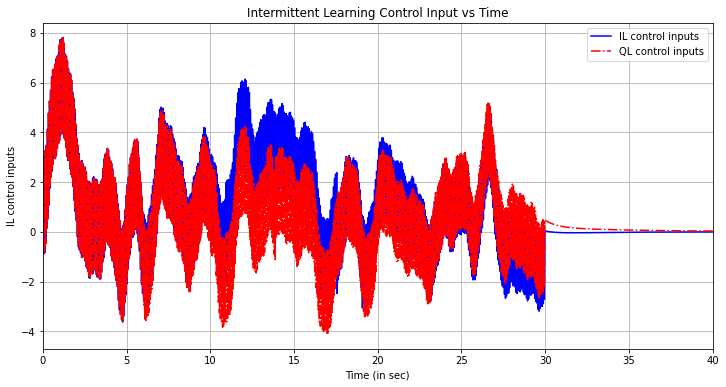

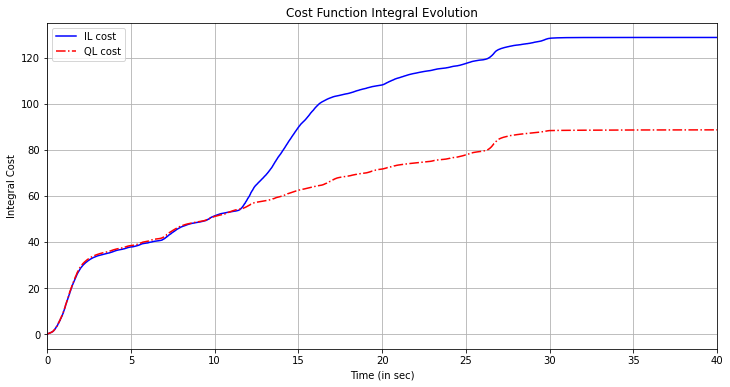

In [80]:
# Controller plot
fig1, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(np.arange(0,100,hh), np.array(u_lseries).reshape(10000), 'b')
ax1.plot(np.arange(0,100,hh), np.array(u_series).reshape(10000), 'r-.')
ax1.legend(('IL control inputs', 'QL control inputs'))
plt.xlim([0, 40])
plt.title('Intermittent Learning Control Input vs Time')
plt.xlabel('Time (in sec)')
plt.ylabel('IL control inputs')
ax1.grid()
# plt.savefig('inputfigure')
plt.show(fig1)


fig2, ax2 = plt.subplots(figsize=(12, 6))
ax2.plot(np.arange(0,100,hh), np.array(p_lseries).reshape(10000), 'b')
ax2.plot(np.arange(0,100,hh), np.array(p_series).reshape(10000), 'r-.')
ax2.legend(('IL cost', 'QL cost'))
plt.xlim([0, 40])
plt.title('Cost Function Integral Evolution')
plt.xlabel('Time (in sec)')
plt.ylabel('Integral Cost')
ax2.grid()
# plt.savefig('costfigure')
plt.show(fig2)


In [9]:
## Reward Loss 2##

U_l2series = []
x_l2series = []
xh_l2series = []
u_l2series = []
Wc_l2series = []
Wu_l2series = []
p_l2series = []

e = np.zeros(x.shape)
U = np.vstack((x,u,e))

U_l2series.append(U)
x_l2series.append(x)
xh_l2series.append(x)
u_l2series.append(u)
Wc_l2series.append(Wc) 
Wu_l2series.append(Wu)
p_l2series.append(p)


for t in np.arange(hh,100,hh):
#     print('t=',t)
    x_n = euler_state(x_l2series[-1], u_l2series[-1])
    x_h = xh_l2series[-1]
    e_x = x_n - x_h
    norme = np.matmul(e_x.T,e_x)
    if norme > 0.1:
        x_h = x_n
        e_x = 0
        
        
    
    step = int(step)
#     print('Wc_series=',Wc_series)
    Q, Qxx, Quu, Qxu, Qb = Qcreate(Wc_l2series[-1])
    Qux = Qxu.T
    
    
    
    if len(p_l2series) < step:
        st = -1
#         p_pp = p_series[-step]
#         u_pp = u_series[-step]
#         x_pp = x_series[-step]
        
    else:
        st = -step
#         p_pp = p_series[-1]
#         u_pp = u_series[-1]
#         x_pp = x_series[-1]
    
    Wc_n = euler_critic(U_l2series[-1], p_l2series[-1], p_l2series[st], U_l2series[st], Wc_l2series[-1], Q)
    Wu_n = euler_actor(x, Wu_l2series[-1], Quu, Qux)
    
#     print('Wc_n = ', Wc_n)
    
    u_new = np.matmul(Wu_n.T,x_h)
    
    if t < T_e:
#         u_n = u_new + 0.2*np.exp(-0.0000001*t)*(np.sin(4*t**2)**2*np.cos(t**2)+np.sin(2**t)**2*np.cos(0.1*t)+np.sin(-1.2*t)**2*np.cos(0.5*t)+np.sin(t)**5+np.sin(1.12*t)**2+np.cos(2.4*t)*np.sin(2.4*t)**3)
        u_n = u_new  + 2*np.exp(-0.01*t)*(np.sin(100*t)+np.sin(t)**2*np.cos(t)+np.sin(2*t)**2*np.cos(0.1*t)+np.sin(-1.2*t)**2*np.cos(0.5*t)+np.sin(t)**5+np.sin(1.12*t)**2+np.cos(2.4*t)*np.sin(2.4*t)**3)
    else:
        u_n = u_new
        
        
    p_past = np.matmul(xh_l2series[-1].T, np.matmul(M, xh_l2series[-1])) + np.matmul(u_l2series[-1].T, np.matmul((R), u_l2series[-1]))
    
    
    p_now = np.matmul(x_h.T, np.matmul(M, x_h)) + np.matmul(u_n.T, np.matmul((R), u_n))
    
    
#     if round(np.random.randn()) > 0: 
#         p_n = p_l2series[-1] + 0.5*hh*p_past  #this is the hold r constant version
#         p_n = p_lseries[-1]   #this is the zero in integral version
#         print('packet loss')
#     else:
#         p_n = p_l2series[-1] + 0.5*hh*p_now
        
    p_n = p_l2series[-1] + 0.5*hh*p_now
    
    x_l2series.append(x_n)
    xh_l2series.append(x_h)
    Wc_l2series.append(Wc_n)
    Wu_l2series.append(Wu_n)
    u_l2series.append(u_n)
    
    
    U_n = np.vstack((x_h,u_n, e_x))
    U_l2series.append(U_n)
    p_l2series.append(p_n)

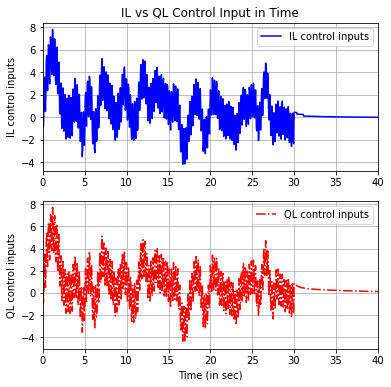

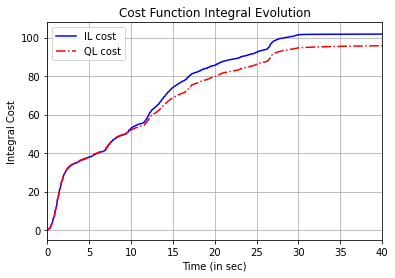

In [10]:
# Controller plot
fig5, (ax5,ax7) = plt.subplots(nrows = 2, ncols = 1, figsize=(6, 6))
ax5.plot(np.arange(0,100,hh), np.array(u_l2series).reshape(2000), 'b')
ax5.legend(['IL control inputs'])
ax5.set_xlim([0, 40])
ax5.set_title('IL vs QL Control Input in Time')
# ax5.set_xlabel('Time (in sec)')
ax5.set_ylabel('IL control inputs')
ax5.grid()

ax7.plot(np.arange(0,100,hh), np.array(u_series).reshape(2000), 'r-.')
ax7.legend(['QL control inputs'])
plt.xlim([0, 40])
# plt.title('QL Control Input vs Time')
plt.xlabel('Time (in sec)')
plt.ylabel('QL control inputs')
ax7.grid()

plt.savefig('inputfigure_l3_hh05short')
plt.show()


fig6, ax6 = plt.subplots(figsize=(6, 4))
ax6.plot(np.arange(0,100,hh), np.array(p_l2series).reshape(2000), 'b')
ax6.plot(np.arange(0,100,hh), np.array(p_series).reshape(2000), 'r-.')
ax6.legend(('IL cost', 'QL cost'))
plt.xlim([0, 40])
plt.title('Cost Function Integral Evolution')
plt.xlabel('Time (in sec)')
plt.ylabel('Integral Cost')
ax6.grid()
plt.savefig('costfigure_l3_hh05short')
plt.show(fig6)

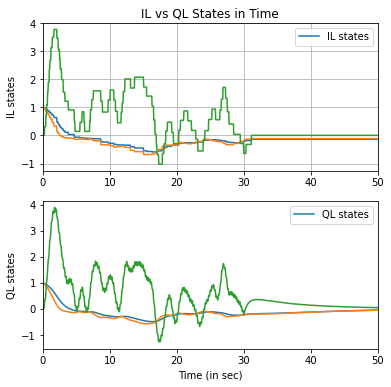

In [11]:
# State plot
states_dat = np.array(x_series).reshape(2000,3).T
states_l2dat = np.array(xh_l2series).reshape(2000,3).T
time_dat = np.arange(0,100,hh)
fig8, (ax8,ax9) = plt.subplots(nrows = 2, ncols = 1, figsize=(6, 6))
ax8.plot(time_dat, states_l2dat[0,:], time_dat, states_l2dat[1,:],time_dat, states_l2dat[2,:])
ax8.legend(['IL states'])
ax8.set_xlim([0, 50])
ax8.set_title('IL vs QL States in Time')
# ax5.set_xlabel('Time (in sec)')
ax8.set_ylabel('IL states')
ax8.grid()

ax9.plot(time_dat, states_dat[0,:], time_dat, states_dat[1,:],time_dat, states_dat[2,:])
# ax9.plot(np.arange(0,100,hh), np.array(x_series[0,:]).reshape(2000), 'r-.')
ax9.legend(['QL states'])
plt.xlim([0, 50])
# plt.title('QL Control Input vs Time')
plt.xlabel('Time (in sec)')
plt.ylabel('QL states')
ax7.grid()

plt.savefig('statefigure_l3_hh05short')
plt.show()

In [12]:
# states_dat = np.array(x_series).reshape(2000,3).T
# states_l2dat = np.array(xh_l2series).reshape(2000,3).T
# time_dat = np.arange(0,100,hh)
# control_dat = np.array(u_l2series).reshape(2000)

r_l2series = []
r_l2series.append(p)

r_series = []
r_series.append(p)


for x_h, u_n in zip(xh_l2series, u_l2series):
    p_now = np.matmul(x_h.T, np.matmul(M, x_h)) + np.matmul(u_n.T, np.matmul((R), u_n))
    r_l2series.append(p_now)
    
    
for x_n, u_n in zip(x_series, u_series):
    p_now = np.matmul(x_n.T, np.matmul(M, x_n)) + np.matmul(u_n.T, np.matmul((R), u_n))
    r_series.append(p_now)

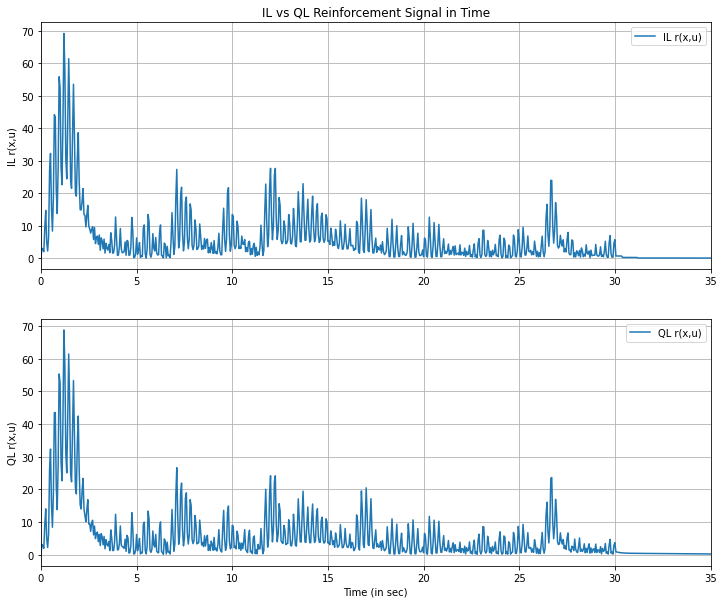

In [13]:
# r(x,u) plot
r_l2dat = np.array(r_l2series[:-1]).reshape(2000)
r_dat = np.array(r_series[:-1]).reshape(2000)
time_dat = np.arange(0,100,hh)


fig10, (ax10,ax11) = plt.subplots(nrows = 2, ncols = 1, figsize=(12, 10))
ax10.plot(time_dat, r_l2dat)
ax10.legend(['IL r(x,u)'])
ax10.set_xlim([0, 35])
ax10.set_title('IL vs QL Reinforcement Signal in Time')
# ax5.set_xlabel('Time (in sec)')
ax10.set_ylabel('IL r(x,u)')
ax10.grid()

ax11.plot(time_dat, r_dat)
# ax9.plot(np.arange(0,100,hh), np.array(x_series[0,:]).reshape(2000), 'r-.')
ax11.legend(['QL r(x,u)'])
plt.xlim([0, 35])
# plt.title('QL Control Input vs Time')
plt.xlabel('Time (in sec)')
plt.ylabel('QL r(x,u)')
ax11.grid()

# plt.savefig('statefigure_l3_hh05short')
plt.show()